In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes

import numpy as np
import pandas as pd
import random

## EDA

In [2]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
ba = AllenAtlas()
pid = '6eb8be8d-d089-43c6-b2e4-a6558ca16dcf'
eid = '9e9c6fc0-4769-4d83-9ea4-b59a1230510e'

In [3]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

In [4]:
spikes

{'depths': array([2800.25170898, 3361.30664062, 2904.30395508, ..., 2028.19030762,
        3678.875     , 3317.64160156]),
 'clusters': array([155, 245, 392, ..., 105, 330, 232], dtype=uint32),
 'amps': array([5.56051677e-05, 1.42381795e-04, 5.43605668e-05, ...,
        8.33171788e-05, 3.97071509e-05, 9.17442225e-05]),
 'times': array([1.66376258e-02, 1.72376258e-02, 1.87042924e-02, ...,
        6.55829322e+03, 6.55829669e+03, 6.55830292e+03])}

In [5]:
# the channels are the physicals probes of the neuropixels. There are 384 probes, hence 384 channels
channels['x'].shape

(384,)

In [6]:
spikes['clusters'][spikes['clusters']==4].shape

(5494,)

In [7]:
spikes['times'].max()

6558.302919443709

In [8]:
spikes.keys()

dict_keys(['depths', 'clusters', 'amps', 'times'])

In [9]:
clusters.keys()

dict_keys(['uuids', 'channels', 'depths', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

In [10]:
for i in clusters:
    print(i, ": ", clusters[i][-105:])

uuids :  383    00634996-716b-4010-9b6c-de6a1eec38b8
384    0ac63ce5-c849-4f72-8535-f646e3b14827
385    51c5ac26-e5d1-48e7-a739-51f182df86f2
386    2c9d476b-5f32-4271-a65f-b6167a4b18aa
387    f1102729-02ed-4d74-9150-63f336509088
                       ...                 
483    e2b5a670-64b6-42f6-93b4-d9c42552ee89
484    b2eb692d-d583-4077-9a1e-c80ff4bf307f
485    e534b8d9-e82a-4ec0-8760-1fe7f35fffb4
486    9803e17b-0bd8-4980-a5ca-d5f4d3df5325
487    7f376dcc-acac-4286-aeca-a822070f7fb0
Name: uuids, Length: 105, dtype: object
channels :  [244 250 250 259 266 270 271 281 281 291 294 295 295 304 305 309 305 308
 310 313 325 321 321 321 325 327 327 331 333 334 338 337 337 338 338 343
 344 344 345 345 345 346 346 346 345 350 352 352 352 354 356 356 357 358
 358 358 360 361 361 360 363 365 361 365 367 367 367 369 369 367 370  34
 244 242 246 266 270 270 294 295 305 305 305 305 316 325 317 333 338 345
 358 358 363 363 365 367  34 244 295 305 321 321 333 363 333]
depths :  [2460. 2520. 2520.

In [11]:
trials.keys()

dict_keys(['goCueTrigger_times', 'stimOff_times', 'response_times', 'feedbackType', 'stimOn_times', 'contrastLeft', 'goCue_times', 'feedback_times', 'rewardVolume', 'contrastRight', 'firstMovement_times', 'choice', 'probabilityLeft', 'intervals'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-12-03_1_ZFM-01576_probe00, 6eb8be8d-d089-43c6-b2e4-a6558ca16dcf \n6_821_862 spikes, 488 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

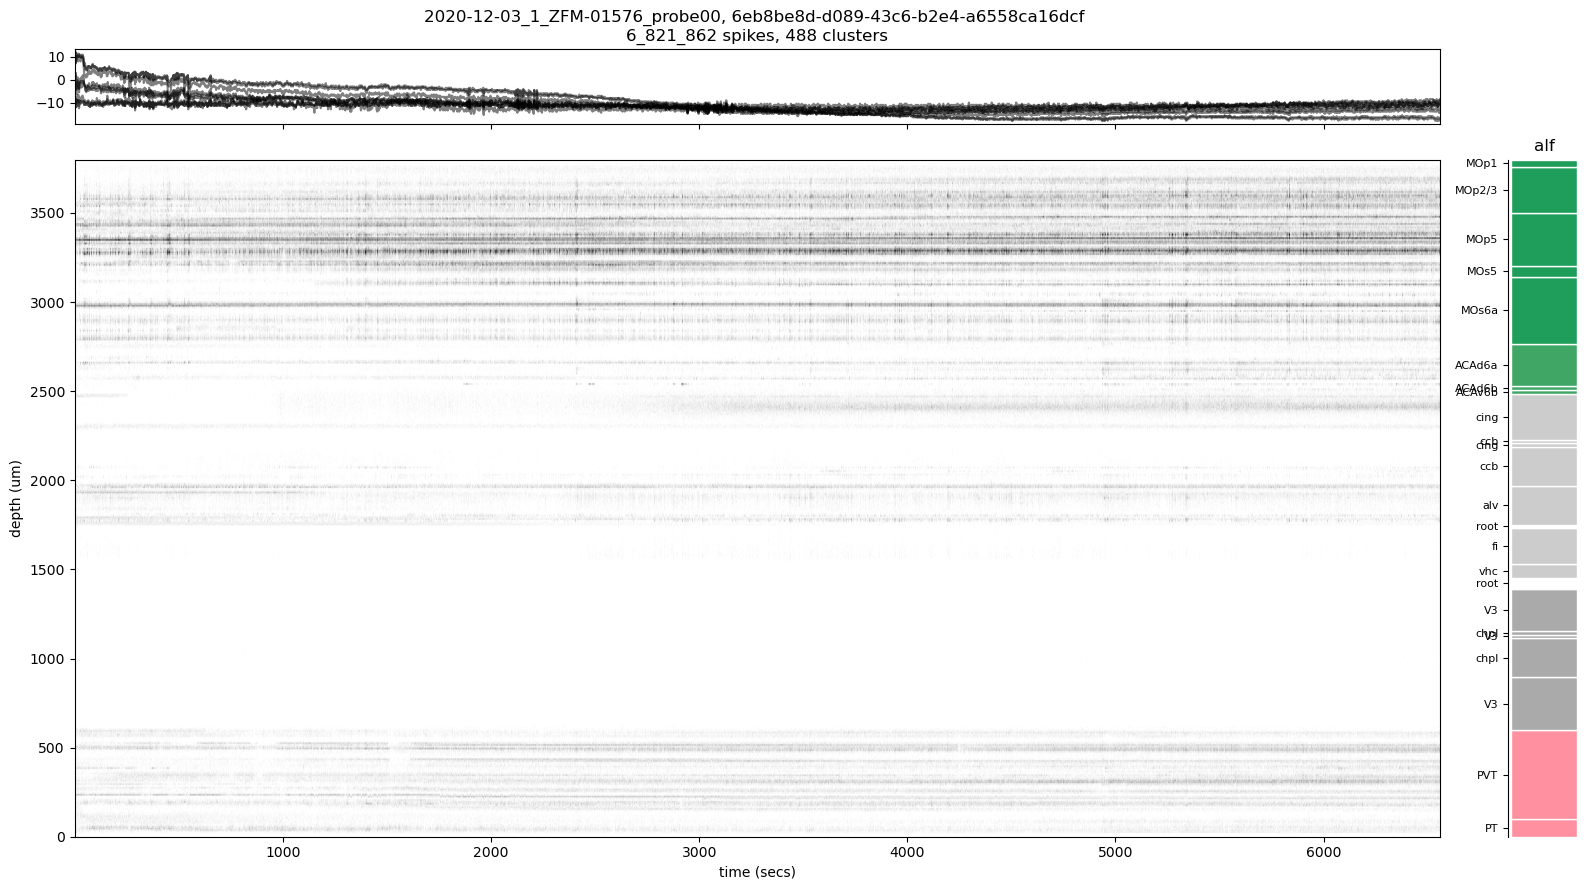

In [12]:
sl.raster(spikes, channels)

### Data Cleaning
1) Filter data for only good clusters (should indicate single neurons), and for brain regions MOp and MOs
2) Group spikes by neurons
3) Split data across trials
4) Bin spike times for each neuron, for each trial

In [13]:
good_clusterIDs = clusters['cluster_id'][((clusters['label'] == 1) & ([True if "MO" in s else False for s in clusters['acronym']]))] # Find good clusters that are in MOp and MOs
# good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1] # Find good clusters that are in MOp and MOs
good_cluster_loc = np.isin(spikes['clusters'], good_clusterIDs)

In [14]:
good_spikes = {}
for i in spikes:
    good_spikes[i] = spikes[i][good_cluster_loc]

In [15]:
good_spikes

{'depths': array([3361.30664062, 2904.30395508, 3339.80297852, ..., 3219.14282227,
        3339.73730469, 3601.29882812]),
 'clusters': array([245, 392, 237, ..., 211, 237, 302], dtype=uint32),
 'amps': array([1.42381795e-04, 5.43605668e-05, 2.33703407e-04, ...,
        2.80053150e-04, 3.18973675e-04, 1.10413923e-04]),
 'times': array([1.72376258e-02, 1.87042924e-02, 2.07709589e-02, ...,
        6.55828192e+03, 6.55828195e+03, 6.55829135e+03])}

In [16]:
channels.keys()

dict_keys(['x', 'y', 'z', 'acronym', 'atlas_id', 'axial_um', 'lateral_um'])

(<Figure size 1600x900 with 4 Axes>,
 array([[<AxesSubplot: title={'center': '2020-12-03_1_ZFM-01576_probe00, 6eb8be8d-d089-43c6-b2e4-a6558ca16dcf \n1_280_696 spikes, 40 clusters'}>,
         <AxesSubplot: >],
        [<AxesSubplot: xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot: title={'center': 'alf'}>]], dtype=object))

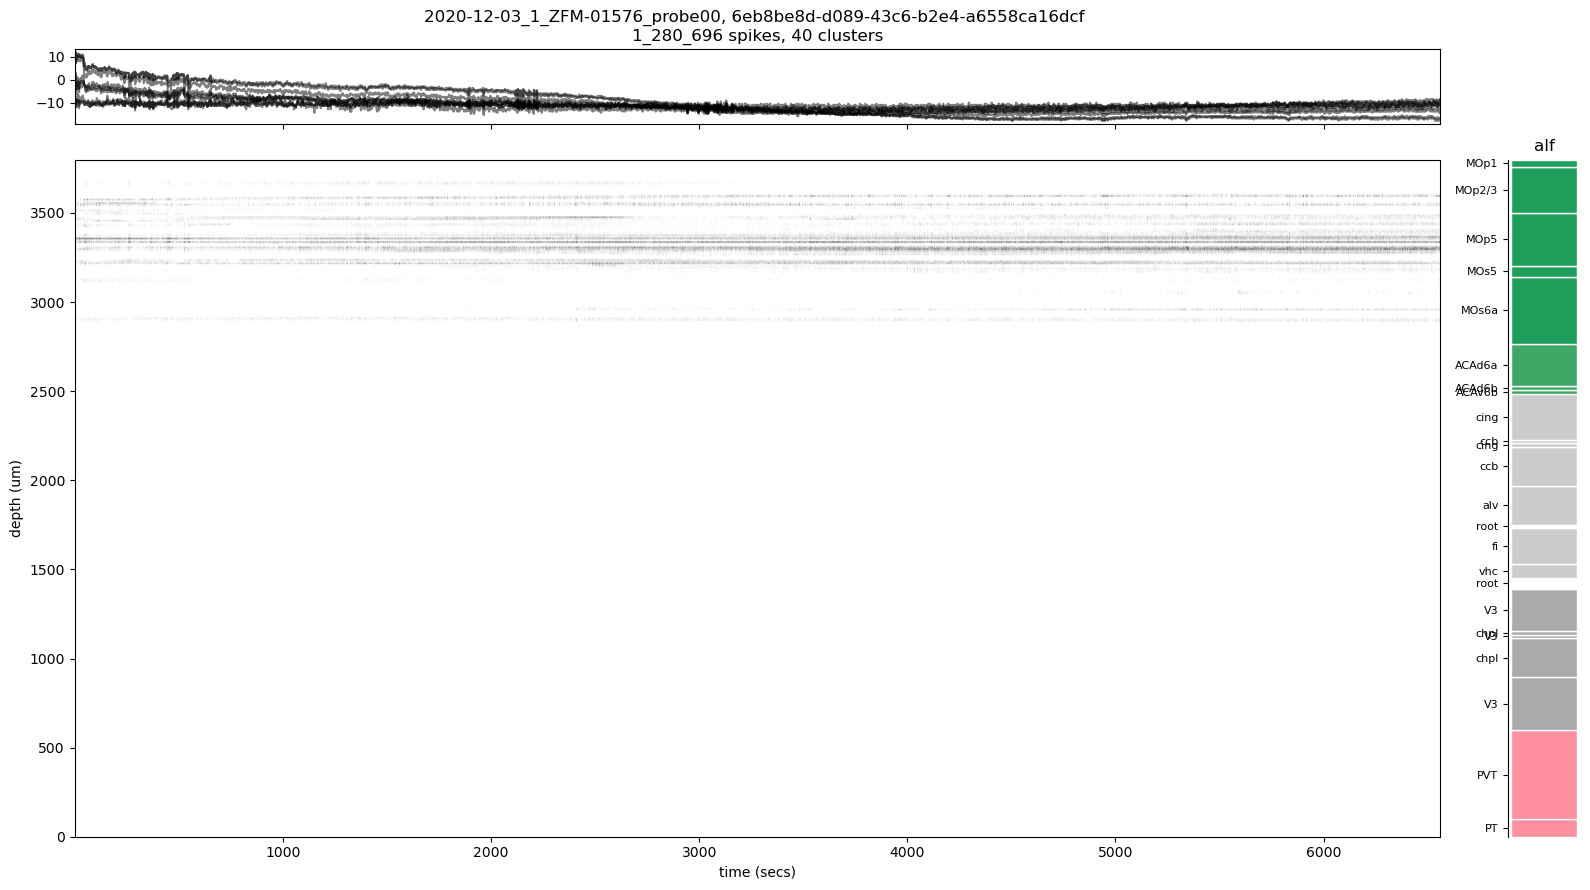

In [17]:
sl.raster(good_spikes, channels)

In [18]:
np.unique(trials['choice'])

array([-1.,  1.])

In [19]:
np.unique(trials['feedbackType'])

array([-1.,  1.])

In [20]:
bin_size = 5e-3 # in milliseconds
# min_bins = max(int((60e-3 / bin_size)), 20)
max_trial_type = 5 # Maximum number of trials of each trial type

In [21]:
# good_spikes
# All trials must have the same number of neurons
df = pd.DataFrame(data = {'clusters':good_spikes['clusters'], 'times':good_spikes['times']})
df = df.groupby('clusters')['times'].apply(np.array)

Implementation with bins as a fixed size:

In [22]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
#     try:
#         hist_bins = np.arange(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i], bin_size)
#     except:
#         continue
#         # the hist bins throw an error if the go cute or first movement time is NaN
#         # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
#     if len(hist_bins) <= min_bins: # Mouse must have a minimum reaction time of 60 ms to be considered a good trial
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], hist_bins)[0])
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with a set number of bins instead of bin size:

In [23]:
# trials_spikes = [] # The Spike times and results of each trial

# for i in range(len(trials['goCueTrigger_times'])):
#     spike_range = {}
    
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
#     x = []
    
#     time_range = (trials['firstMovement_times'][i] - trials['goCue_times'][i])
#     if ((time_range < 0.10) | (time_range > 0.300)): # Mouse must have a minimum reaction time of 60 ms to be considered a good trial. We also exlude trials longer than 300 ms because they will have too many spikes per bin
#         continue
    
#     for j in df: # Iterate through spike times of each cluster
#         inds = ((j>trials['goCueTrigger_times'][i]) & (j<=trials['firstMovement_times'][i])) # From go queue to first movement
#         # print(np.histogram(j[inds], hist_bins)[0])
#         x.append(np.histogram(j[inds], 200)[0]) # 200 bins
    
#     spikes_df = pd.DataFrame(x, index=df.index)
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

Implementation with bins starting 100ms before first movement to 300 ms after first movement

In [24]:
trials_spikes = [] # The Spike times and results of each trial

for i in range(len(trials['goCueTrigger_times'])):
    spike_range = {}
    
    spike_range['goCue_times'] = trials['goCue_times'][i]
    spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
    spike_range['choice'] = trials['choice'][i]
    spike_range['feedbackType'] = trials['feedbackType'][i]
    
    x = []
    try:
        hist_bins = np.arange(trials['firstMovement_times'][i]-0.1, trials['firstMovement_times'][i]+1, bin_size)
    except:
        continue
        # the hist bins throw an error if the go cue or first movement time is NaN
        # print(trials['goCueTrigger_times'][i], trials['firstMovement_times'][i])
    
    
    for j in df: # Iterate through spike times of each cluster
        inds = ((j>(trials['firstMovement_times'][i]-0.1)) & (j<=(trials['firstMovement_times'][i]+1))) # From go queue to first movement
        # print(np.histogram(j[inds], hist_bins)[0])
        x.append(np.histogram(j[inds], hist_bins)[0])
    
    spikes_df = pd.DataFrame(x, index=df.index)
    spike_range['spikes_df'] = spikes_df
    
    trials_spikes.append(spike_range)

In [25]:
random.shuffle(trials_spikes) # Randomize list before splitting into training and testing data

In [26]:
len(trials_spikes)

1005

In [27]:
training_trials = []
testing_trials = []


trial_counts = {"correct_left" : [0, 0],  # [training count, testing count]
                "correct_right" : [0, 0],
                "incorrect_left" : [0, 0], # incorrect left means that the mouse chose left, and it was incorrect
                "incorrect_right": [0, 0]}

for i in trials_spikes:
    if ((i["choice"]==-1) & (i["feedbackType"]==1)):
        if trial_counts['correct_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_left'][0] += 1
        elif trial_counts['correct_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==1)):
        if trial_counts['correct_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['correct_right'][0] += 1
        elif trial_counts['correct_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['correct_right'][1] += 1
        else:
            continue
    elif ((i["choice"]==-1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_left'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_left'][0] += 1
        elif trial_counts['incorrect_left'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_left'][1] += 1
        else:
            continue
    elif ((i["choice"]==1) & (i["feedbackType"]==-1)):
        if trial_counts['incorrect_right'][0] < max_trial_type:
            training_trials.append(i)
            trial_counts['incorrect_right'][0] += 1
        elif trial_counts['incorrect_right'][1] < max_trial_type:
            testing_trials.append(i)
            trial_counts['incorrect_right'][1] += 1
        else:
            continue

In [28]:
len(training_trials)

20

In [29]:
# training_trials[0]["spikes_df"]

In [30]:
# trials_spikes = [] # The Spike times and results of each trial

# for i, interval in enumerate(trials['intervals']):
#     time_range = ((good_spikes['times']>interval[0]) & (good_spikes['times']<interval[1])) #Find the spikes corresponding to the current interval
#     spike_range = {}
    
#     for key in good_spikes:
#         spike_range[key] = good_spikes[key][time_range]
        
#     spike_range['goCue_times'] = trials['goCue_times'][i]
#     spike_range['firstMovement_times'] = trials['firstMovement_times'][i]
#     spike_range['choice'] = trials['choice'][i]
#     spike_range['feedbackType'] = trials['feedbackType'][i]
    
    
#     # Bin Spikes based on time= 0.1 seconds, per cluster
#     df = pd.DataFrame(data={'clusters':spike_range['clusters'], 'times':spike_range['times']})
#     hist_bins = np.arange(interval[0], interval[1], 0.1)
#     df = df.groupby('clusters')['times'].apply(list)
    
#     hist_rows = []
#     for i in df.iloc:
#         hist_rows.append(np.histogram(i, hist_bins)[0])
#     spikes_df = pd.DataFrame(hist_rows, columns=hist_bins[:-1], index=df.index) # Clusters are assumed to be good neurons
#     spike_range['spikes_df'] = spikes_df
    
#     trials_spikes.append(spike_range)

In [31]:
# sl.raster(trials_spikes[3], channels)

In [32]:
import math

import jax.random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from vlgpax.model import Session
from vlgpax.kernel import RBF, RFF
from vlgpax import vi

In [33]:
training_trials[0]['spikes_df'].T

clusters,166,173,183,198,204,210,211,215,223,225,...,297,301,302,327,392,401,414,421,422,424
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
216,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
session = Session(bin_size)
# y = pd.read_csv("neural_data.csv")
# session.add_trial(0, y=y)
for i, trial in enumerate(training_trials):
    # print(trial['spikes_df'].T.shape)
    session.add_trial(i, y=trial['spikes_df'].T)

In [35]:
length_scale = 0.005# in seconds
kernel = RBF(scale=1, lengthscale=20*bin_size)

In [36]:
session, params = vi.fit(session, n_factors=3, kernel=kernel, seed=0, max_iter=15, trial_length=20, GPFA=True)

Initializing
Initialized


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning: M: loss increased
  warnings.warn('M: loss increased')
c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')
c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:173: UserWarning: E: maximum number of iterations reached
  warnings.warn(f'E: maximum number of iterations reached')


EM Iteration 1, 	Loss = 1731.5005, 	M step: 3.11s, 	E step: 9.30s


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:270: UserWarning: M: loss increased
  warnings.warn('M: loss increased')


EM Iteration 2, 	Loss = -0.8999, 	M step: 1.45s, 	E step: 7.28s
EM Iteration 3, 	Loss = -18.7810, 	M step: 1.87s, 	E step: 6.84s
EM Iteration 4, 	Loss = -1.8371, 	M step: 1.43s, 	E step: 6.76s
Inferring


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:408: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


Trial 0, 	Loss = -21.7738


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 1, 	Loss = -3.2029
Trial 2, 	Loss = -22.1722
Trial 3, 	Loss = -21.6369


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 4, 	Loss = -21.6512
Trial 5, 	Loss = 553.8485
Trial 6, 	Loss = 292.1712
Trial 7, 	Loss = -23.1124
Trial 8, 	Loss = -8.5199
Trial 9, 	Loss = -22.5970
Trial 10, 	Loss = 1097.3160
Trial 11, 	Loss = -22.2030
Trial 12, 	Loss = -7.3007
Trial 13, 	Loss = -22.8061
Trial 14, 	Loss = -2.0019
Trial 15, 	Loss = -22.0839
Trial 16, 	Loss = 18.0159
Trial 17, 	Loss = 9063.2678
Trial 18, 	Loss = -21.7873
Trial 19, 	Loss = -21.2264
Finished


In [37]:
# trials_spikes[2]['spikes_df'].T.to_csv("neural_data.csv")

In [38]:
import plotly.express as px

In [39]:
from sklearn.preprocessing import StandardScaler

Trial 0, 	Loss = -21.7738


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


0
Trial 2, 	Loss = -22.1722
2
Trial 3, 	Loss = -21.6369


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



3
Trial 4, 	Loss = -21.6512
4
Trial 6, 	Loss = 292.1712


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



6
Trial 9, 	Loss = -22.5970
Trial 11, 	Loss = -22.2030


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 12, 	Loss = -7.3007
Trial 15, 	Loss = -22.0839


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 16, 	Loss = 18.0159


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



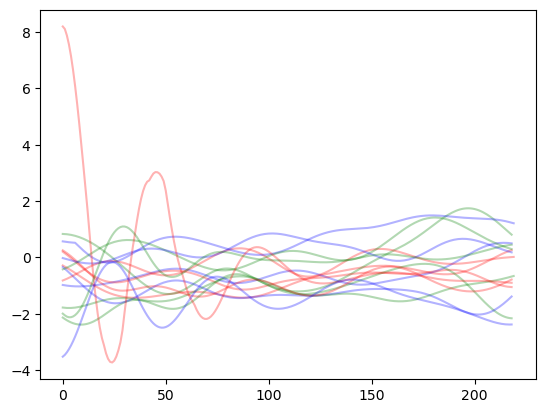

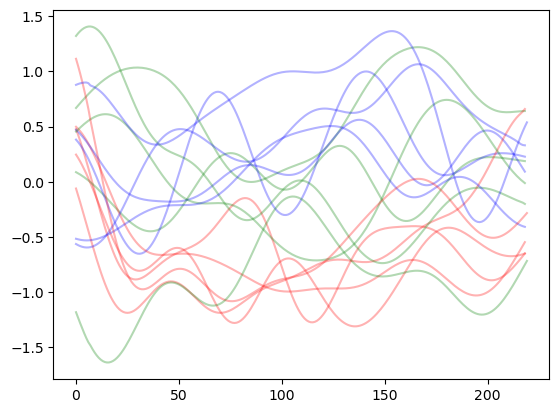

In [40]:
first = True
correct_left = np.array([])
for i, trial in enumerate(training_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        # values = StandardScaler().fit_transform(sessionTest.z)
        values = sessionTest.z
        print(i)
        if first:
            fig = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["blue"]*len(values), width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)
            
        fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'black', 'size':5}) # Marks the end point of the trial
        plt.figure(1)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
        
    elif ((trial['choice']==-1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        # values = StandardScaler().fit_transform(sessionTest.z)
        values = sessionTest.z
        if first:
            fig  = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["red"]*len(values), width=800, height=800)
            first = False
        else:
            fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)
        fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'green', 'size':5}) # Marks the end point of the trial
        plt.figure(2)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
fig.show()
plt.show()

In [41]:
fig  = px.line_3d(x=session.z[:, 0], y=session.z[:, 1], z=session.z[:, 2], color=["blue"]*len(session.z), width=800, height=800)
fig.show()

In [42]:
first = True
correct_left = []
correct_right = []

for i, trial in enumerate(training_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        correct_right.append(values)
        # values = sessionTest.z
        # print(i)
        # if first:
        #     fig = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["blue"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"blue"}, opacity=0.5)
            
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'black', 'size':5}) # Marks the end point of the trial
        # plt.figure(1)
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
        
    elif ((trial['choice']==-1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        correct_left.append(values)
        # values = sessionTest.z
        # if first:
        #     fig  = px.line_3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], color=["red"]*len(values), width=800, height=800)
        #     first = False
        # else:
        #     fig.add_scatter3d(x=values[:, 0], y=values[:, 1], z=values[:, 2], mode='lines', line={'color':"red"}, opacity=0.5)
        # fig.add_scatter3d(x=values[-1:, 0], y=values[-1:, 1], z=values[-1:, 2], marker={'color':'green', 'size':5}) # Marks the end point of the trial
        # plt.figure(2)
        # plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 3], color='orange', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 4], color='black', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 5], color='purple', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 6], color='brown', alpha=0.3)
        # plt.plot(np.arange(0, len(values), 1), values[:, 7], color='yellow', alpha=0.3)
# fig.show()
# plt.show()

Trial 0, 	Loss = -21.7738
Trial 2, 	Loss = -22.1722
Trial 3, 	Loss = -21.6369


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 4, 	Loss = -21.6512
Trial 6, 	Loss = 292.1712


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 9, 	Loss = -22.5970
Trial 11, 	Loss = -22.2030


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



Trial 12, 	Loss = -7.3007
Trial 15, 	Loss = -22.0839
Trial 16, 	Loss = 18.0159


c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased

c:\Users\asing\anaconda3\envs\lvmworkshop\lib\site-packages\vlgpax\vi.py:163: UserWarning:

E: loss increased



In [43]:
correct_right_m = np.array(correct_right).mean(axis=0)
correct_left_m = np.array(correct_left).mean(axis=0)

C:\Users\asing\AppData\Local\Temp\ipykernel_35880\2448259924.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: operands could not be broadcast together with shapes (219,3) (220,3) 

In [ ]:
plt.figure(3)
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 0], color='red')
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 1], color='green')
plt.plot(np.arange(0, len(correct_right_m)), correct_right_m[:, 2], color='blue')
plt.figure(4)
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 0], color='red')
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 1], color='green')
plt.plot(np.arange(0, len(correct_left_m)), correct_left_m[:, 2], color='blue')

In [ ]:
for i, trial in enumerate(testing_trials):
    if ((trial['choice']==1) & (trial['feedbackType']==1)):
        sessionTest = Session(bin_size)
        sessionTest.add_trial(i, y=trial['spikes_df'].T)
        sessionTest = vi.infer(sessionTest, params=params)
        values = StandardScaler().fit_transform(sessionTest.z)
        plt.figure(i)
        plt.plot(np.arange(0, len(values), 1), values[:, 0], color='red')
        plt.plot(np.arange(0, len(values), 1), values[:, 1], color='green')
        plt.plot(np.arange(0, len(values), 1), values[:, 2], color='blue')

In [ ]:
len(correct_left)

In [ ]:
correct_right